## Imports

In [714]:
import pandas as pd
from datetime import datetime, date, time
#import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from bokeh.plotting import figure, show
from bokeh.models import ColumnDataSource
from bokeh.models import NumeralTickFormatter
from bokeh.io import output_notebook
output_notebook()

import plotly.express as px

import seaborn as sns

import folium


Loading BokehJS ...

## Parameter setup

In [553]:
import_file = 'Data/records-2022-11-02.csv'
export_file = 'Data/export-' #time stamp and .csv will be added at write stage

years = []
for f in range(2003,2022):
    years.append(str(f))

dw.head()
col_to_drop = ["NBN Atlas record ID","Licence","Rightsholder","Occurrence status","Taxon author","Taxon Rank","Country","Recorder","Dataset ID","Data provider","Dataset name","Data provider ID",'Class','Order','Family','Kingdom','Basis of record','Species ID (TVK)','Institution code','Vitality','Identification verification status','Phylum','Genus']

## Import Data

In [458]:
dw = pd.read_csv(import_file, parse_dates=["Start date"])

## Data Cleanse

In [514]:
# Drop columns we don't need
dw = dw.drop(col_to_drop, axis='columns', errors='ignore')
# drop empty columns
dw = dw.dropna(axis='columns', how='all') 

In [515]:
# Rename columns
dw.columns = dw.columns.str.replace("Start date","Date")
dw.columns = dw.columns.str.replace("State/Province","Country")
dw.head()

,Occurrence ID,Scientific name,Common name,Date,Date day,Date month,Date year,OSGR,Latitude (WGS84),Longitude (WGS84),Coordinate uncertainty (m),Individual count,Life stage,OSGR 100km,OSGR 10km,OSGR 2km,OSGR 1km,Country
0,13277,Orcinus orca,Killer Whale,2019-12-20,20,12,2019,NM36,56.667782,-6.296667,1000.0,1.0,NaN,NM,NM36,NaN,NaN,Scotland
1,13273,Halichoerus grypus,Grey Seal,2019-11-26,26,11,2019,NM3966,56.720737,-6.260450,220.0,1.0,NaN,NM,NM36,NM36Y,NM3966,Scotland
2,13271,Phocoena phocoena,Common Porpoise,2019-11-26,26,11,2019,NM5976,56.815250,-5.942466,400.0,1.0,NaN,NM,NM57,NM57Y,NM5976,Scotland
3,14169,Delphinus delphis,Common Dolphin,2021-11-05,5,11,2021,NM2470,56.742290,-6.507234,150.0,1.0,NaN,NM,NM27,NM27K,NM2470,Scotland
4,13261,Phocoena phocoena,Common Porpoise,2019-11-25,25,11,2019,NM5175,56.805698,-6.072366,200.0,1.0,NaN,NM,NM57,NM57C,NM5175,Scotland


In [517]:
# Graph missing data
null_plot = dw.isna().sum()
null_plot = null_plot[null_plot > 0]
null_plot = null_plot.sort_values()
px.bar(null_plot, orientation='h',text_auto=True, title='Missing data').update_layout(yaxis_title='Column', xaxis_title='Count', showlegend=False)

Repair Individual Count

In [469]:
# Repair Individual count data
# Fill missing counts with 1
dw['Individual count'] = dw['Individual count'].fillna(1)
# Reduce outliers to 1
dw.loc[dw['Individual count'] > 100, 'Individual count'] = 1

Repair Life Stage

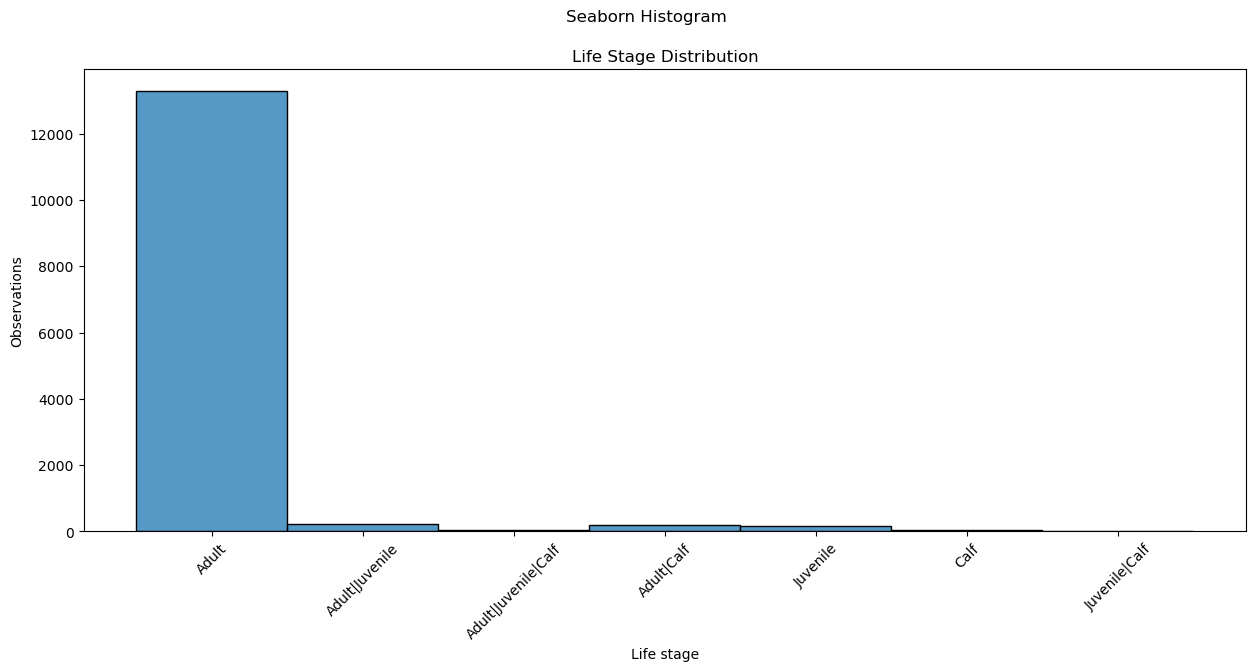

In [613]:
fig, ax = plt.subplots(figsize=(15,6))
sns.histplot(data=dw, x='Life stage')
fig.suptitle('Seaborn Histogram')
ax.set_title("Life Stage Distribution")
ax.set_ylabel('Observations')
ax.tick_params(axis='x', rotation=45)
plt.show()

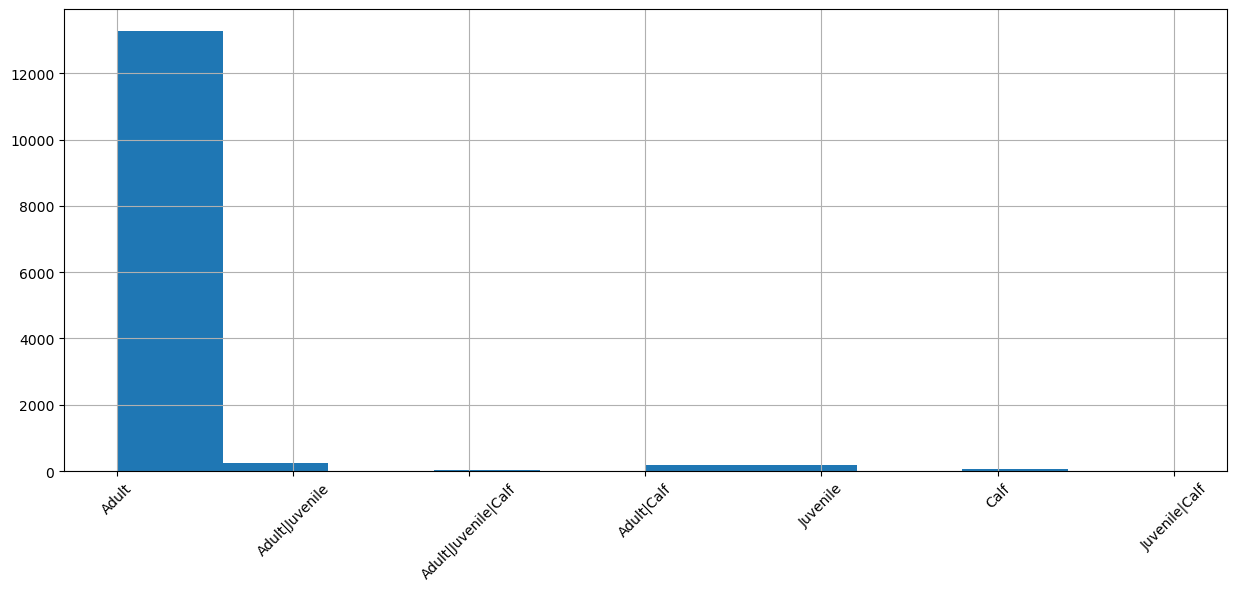

In [610]:
dw['Life stage'].hist(xrot=45,figsize=(15,6))
plt.show()

In [611]:
# Set missing Life stage to Adult
dw['Life stage'] = dw['Life stage'].fillna('Adult')

In [635]:
fig = px.histogram(dw, x='Life stage', orientation='v',text_auto=True)
fig.update_layout(yaxis_title='Observations', xaxis_title='Life Stage')
fig.show()

## Save clean data to external file

In [561]:
file_dt = datetime.now()
file_dt = file_dt.strftime('%F')
save_file = export_file + file_dt + '.csv'
dw.to_csv(save_file)

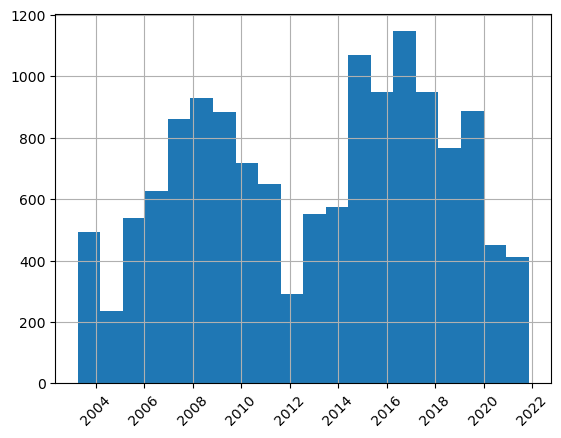

In [519]:
dw['Date'].hist(bins=20,xrot=45)
plt.show()

In [713]:
fig = px.histogram(dw, x='Date', nbins=20,text_auto=False, title="Observations over time", color='Common name')
fig.update_layout(yaxis_title='Observations', xaxis_title='')
fig.show()

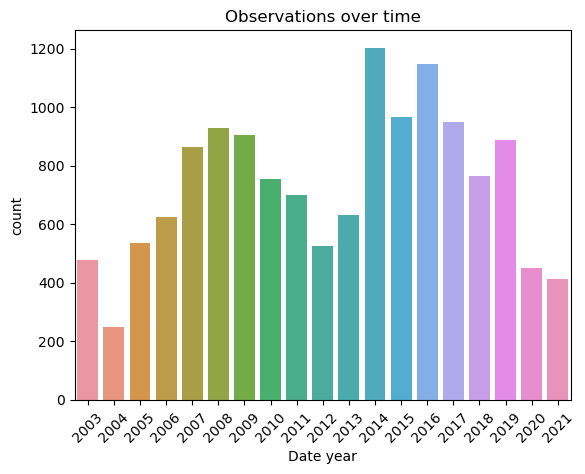

In [538]:
g = sns.countplot(data=dw,x='Date year')
g.set_xticklabels(labels=years,rotation=45)
plt.title("Observations over time")
plt.show()

In [626]:
dw_totals = dw.groupby(['Common name'])[['Individual count']].sum()
dw_totals = dw_totals.reset_index()
dw_totals = dw_totals.sort_values(by='Individual count')

fig = px.bar(dw_totals,y='Common name', x='Individual count', text_auto=False)
fig.update_layout(title='Total Spotted Individuals')
fig.show()

In [641]:
df_dolphins = dw[dw['Common name'] == 'Common Porpoise']
df_dolphins_grp_year = df_dolphins.groupby('Date year')[['Individual count']].sum()
fig = px.line(df_dolphins_grp_year, title="Porpoises Spotted Over Time")
fig.update_layout(yaxis_title='Count of Porpoises', xaxis_title='', showlegend=False)
fig.show()

In [652]:
tmp = dw.groupby(['Common name',"Date year"])[['Individual count']].sum()
tmp = tmp.reset_index()
tmp_pv = tmp.pivot_table(index="Date year", columns='Common name', values='Individual count')
tmp_pv = tmp_pv.fillna(0)

tmp_pv = tmp_pv.reset_index()

In [670]:
tmp_pv

Common name,Date year,Atlantic White-sided Dolphin,Basking Shark,Bottle-nosed Dolphin,Common Dolphin,Common Porpoise,Eurasian Otter,Fin Whale,Grey Seal,Harbour Seal,Humpback Whale,Killer Whale,Leathery Turtle,Long-finned Pilot Whale,Minke Whale,Risso's Dolphin,Striped Dolphin,Sun-fish,White-beaked Dolphin
0,2003,0.0,83.0,29.0,50.0,415.0,0.0,0.0,78.0,40.0,0.0,1.0,0.0,0.0,87.0,42.0,1.0,2.0,7.0
1,2004,0.0,43.0,8.0,0.0,208.0,0.0,0.0,34.0,16.0,0.0,6.0,0.0,1.0,52.0,1.0,0.0,1.0,0.0
2,2005,0.0,111.0,5.0,73.0,609.0,0.0,0.0,99.0,76.0,0.0,15.0,0.0,0.0,42.0,10.0,0.0,8.0,0.0
3,2006,0.0,241.0,27.0,134.0,452.0,0.0,0.0,133.0,33.0,1.0,0.0,0.0,0.0,45.0,3.0,0.0,1.0,18.0
4,2007,0.0,130.0,29.0,392.0,834.0,0.0,0.0,169.0,50.0,1.0,9.0,0.0,0.0,52.0,25.0,0.0,5.0,95.0
5,2008,33.0,155.0,22.0,228.0,784.0,0.0,1.0,178.0,126.0,0.0,12.0,0.0,0.0,50.0,14.0,0.0,3.0,68.0
6,2009,75.0,199.0,14.0,265.0,662.0,0.0,0.0,238.0,145.0,1.0,4.0,0.0,0.0,65.0,20.0,0.0,2.0,107.0
7,2010,0.0,360.0,18.0,381.0,489.0,0.0,0.0,108.0,106.0,0.0,0.0,0.0,0.0,44.0,0.0,0.0,3.0,34.0
8,2011,0.0,52.0,2.0,780.0,594.0,0.0,1.0,199.0,65.0,0.0,0.0,1.0,0.0,73.0,15.0,0.0,2.0,149.0
9,2012,0.0,188.0,22.0,315.0,273.0,0.0,0.0,130.0,98.0,0.0,5.0,0.0,0.0,50.0,6.0,0.0,2.0,35.0


In [711]:

fig = px.line(
    tmp_pv, x='Date year' , 
    y=["Common Dolphin","Common Porpoise"], 
    title="Dolphins vs Porpoises Over Time",
    )
    
fig.update_layout(yaxis_title='Number Spotted', xaxis_title='', showlegend=True, legend_title='')
#fig.update_traces(line_dash="Common Dolphin")
fig.show()

In [717]:

#dw.loc[dw['Date'] > '2021-07-18': dw['Date'] < '2021-07-30']
tmp = dw.loc[dw['Date'] >= '2021-01-01']
tmp = tmp.loc[dw['Common name'] == "Risso's Dolphin"]
tmp

,Occurrence ID,Scientific name,Common name,Date,Date day,Date month,Date year,OSGR,Latitude (WGS84),Longitude (WGS84),Coordinate uncertainty (m),Individual count,Life stage,OSGR 100km,OSGR 10km,OSGR 2km,OSGR 1km,Country
12763,14110,Grampus griseus,Risso's Dolphin,2021-08-24,24,8,2021,NL72,56.28459,-7.190283,800.0,1.0,Adult,NL,NL72,NaN,NaN,Scotland


In [730]:
m = folium.Map(
    location=[56.28459, -7.190283],
    tiles="cartodbpositron",
    zoom_start=8,
    )


In [731]:
m

[0.19090878 0.85925996 0.50109664 0.80391441]


C:\Users\laptop\AppData\Local\Temp\ipykernel_13644\2831104114.py:6: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



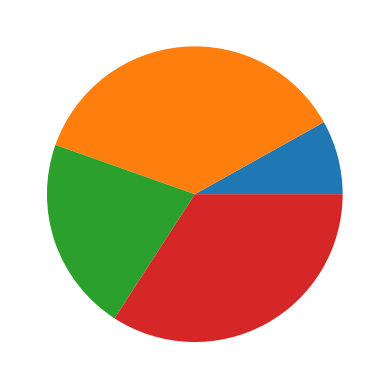

In [338]:
fig, ax = plt.subplots()
Z = np.random.uniform(0, 1, 4)
Z = 
print(Z)
ax.pie(Z)

fig.show()

In [ ]:
dw["Real_count"] = realcount(dw.Common_name,dw.Count)
#dw["Real_count"] = dw["Count"].apply(mycount, common_name = dw["Common_name"])
dw.Real_count.describe()

In [ ]:
dw.Real_count.sum()

In [ ]:
# Boxplot
plt.figure(figsize=(6,6)) # Set plot dimensions
sns.boxplot(data=dw.Real_count)

In [ ]:
# Boxplot
plt.figure(figsize=(20,5)) # Set plot dimensions
plt.xticks(rotation=-90)
sns.boxplot(data=dw, x="Common_name", y="Count")

In [ ]:
# Boxplot
plt.figure(figsize=(20,5)) # Set plot dimensions
plt.xticks(rotation=-90)
sns.boxplot(data=dw, x="Common_name", y="Real_count")

In [ ]:
# Count Plot (a.k.a. Bar Plot)
plt.figure(figsize=(25,6))
# Rotate x-labels
plt.xticks(rotation=-70)
sns.countplot(x='Common_name', data=dw)

In [ ]:
porpoise = dw[dw.Common_name == "Common Porpoise"][:]
print("Common Porpoise = ", len(porpoise))
print("Common Porpoise = ", sum(porpoise.Count))
print("Common Porpoise Real Count = ", sum(porpoise.Real_count))

In [ ]:
porpoise.head()

In [ ]:
plt.scatter(por.Date_year,dw.Count)

In [ ]:
sns.lmplot(x='Date_month', y='Count', data=porpoise,
fit_reg=False)

In [ ]:
plt.hist( dw.Date_year)

In [ ]:
plt.scatter(dw.Date_year,dw.Count)
plt.figure(figsize=(40,6))

In [ ]:
dw.Date_year.describe()

In [ ]:
dw.Real_count.describe()

In [ ]:
sns.lmplot(x='Date_year', y='Real_count', data=dw,
fit_reg=False,
hue='Common_name')
plt.figure(figsize=(20,6))